In [31]:
import numpy as np  
import matplotlib.pyplot as plt
import torch

In [32]:
n_train = 500
torch.manual_seed(42)
# Create a random dataset [-1, 1] x [-1, 1]
#X_train = torch.rand(n_train, 1) * 2 - 1
X_train = torch.randn(n_train, 1)

# Sort the data
X_train, _ = torch.sort(X_train, dim=0)
X_train[:5]

tensor([[-2.5850],
        [-2.5095],
        [-2.4885],
        [-2.4801],
        [-2.3184]])

In [33]:
from sklearn.preprocessing import PolynomialFeatures

# Create a polynomial feature transformer
poly = PolynomialFeatures(degree=5)

# Create polynomial features
X = poly.fit_transform(X_train)
X = torch.tensor(X, dtype=torch.float32)
print(X.shape)
# X[:,0] - 1
# X[:,1] - X_train[:,0]
# X[:,2] - X_train[:,0]**2

torch.Size([500, 26])


In [34]:
# standardize the data
X = (X - X.mean(dim=0)) / X.std(dim=0)
X[:,0] = 1
# (X[:,2] - X.mean(dim=0)[2]) - (X - X.mean(dim=0))[:,2]

tensor([ 1., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

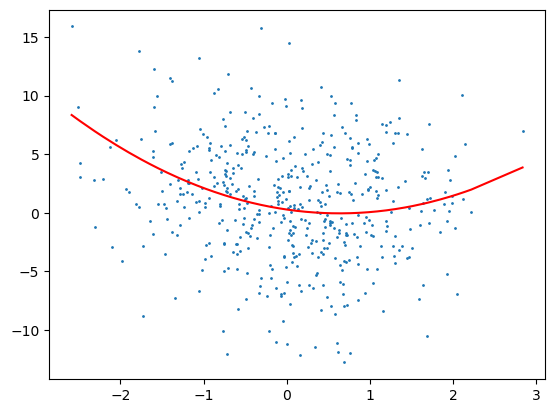

In [35]:
theta_tru = torch.tensor([1, -1, 1], dtype=torch.float32)*1
theta_tru = torch.cat([theta_tru, torch.zeros(X.shape[1] - theta_tru.shape[0])])
# theta_tru = torch.tensor([-0.4527545, 0.1877339, -0.6796304, 0, 0, 0], dtype=torch.float32)

# torch.manual_seed(1337)
# theta_tru = 5*torch.randn(3)
# pad theta_tru with zeros


# theta_tru = torch.randn(X.shape[1])
sig = 1
f_tru = X @ theta_tru
y_train = f_tru + torch.randn(n_train) * sig

# Plot the data
plt.scatter(X_train, y_train, s=1)
plt.plot(X_train, f_tru, color='red')
theta_tru

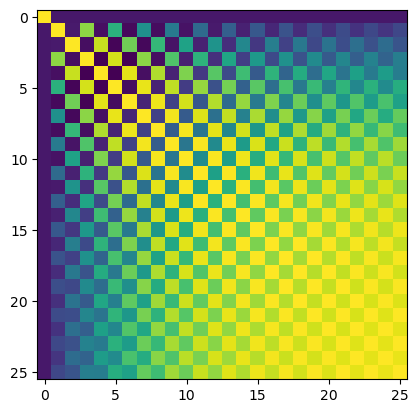

In [36]:
Cxx = X.T @ X / n_train # Covariance of X
Cxy = X.T @ y_train / n_train # Cross covariance of X and y

# plot Cxx
plt.imshow(Cxx)

tensor([   0.9171,   -2.8567,    0.3196,   11.6562,   11.4903,  -28.0518,
         -29.4641,   20.8199,  -20.4752,   10.0326,   80.8496,  -11.6959,
          67.2552,   37.5114,  -88.0569,  -24.5361, -195.2107,  -17.4951,
         125.3801, -109.1803,   16.9062,   91.8450,   41.2751,  -50.2756,
          -7.5424,   69.2308])


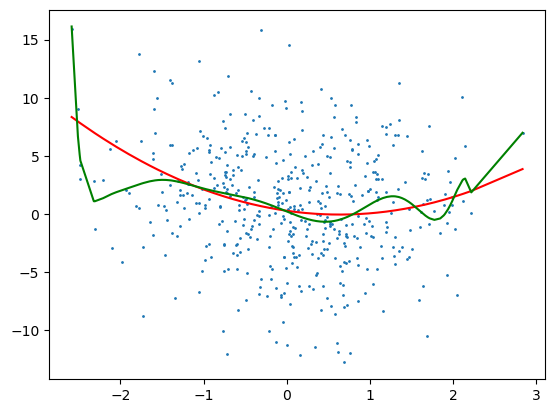

In [37]:
# Ridge regression
# theta_ridge = torch.solve(Cxy[:,None], C + regparam * torch.eye(C.shape[0]))[0].squeeze()

def solve_ridge(Cxx, Cxy, regparam):
    return torch.linalg.solve(Cxx + regparam * torch.eye(Cxx.shape[0]), Cxy[:,None]).squeeze()

theta_ridge = solve_ridge(Cxx, Cxy, regparam = 0)
print(theta_ridge)

# plot the ridge regression solution
f_ridge = X @ theta_ridge
plt.scatter(X_train, y_train, s=1)
plt.plot(X_train, f_tru, color='red')
plt.plot(X_train, f_ridge, color='green')


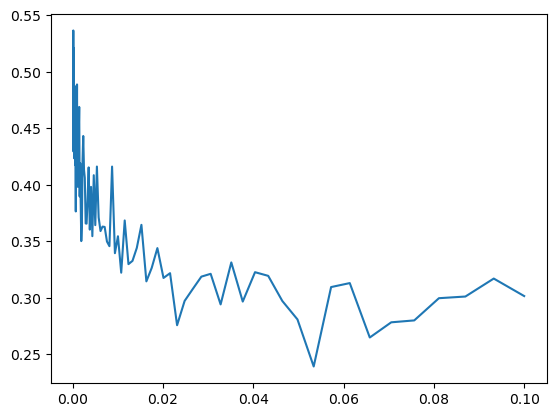

In [38]:
from itertools import product
import pandas as pd

n_reps = 50
n_regparams = 100
regparams = np.logspace(-4, -1, n_regparams)
res = []
for rep, regparam in product(range(n_reps), regparams):
    y_train = f_tru + torch.randn(n_train) * sig
    
    Cxy = X.T @ y_train / n_train
    theta_ridge = solve_ridge(Cxx, Cxy, regparam)
    f_ridge = X @ theta_ridge
    # loss = torch.mean((f_ridge - y_train)**2).item()
    loss = torch.mean((f_tru - f_ridge)**2).item()
    # store rep, regparam, loss
    res.append({'rep':rep, 'regparam':regparam, 'loss':loss})

res = pd.DataFrame(res)

# average over repetitions
res = res.groupby('regparam').mean().reset_index()

# plot the results
plt.plot(res.regparam, res.loss)
#plt.xscale('log')

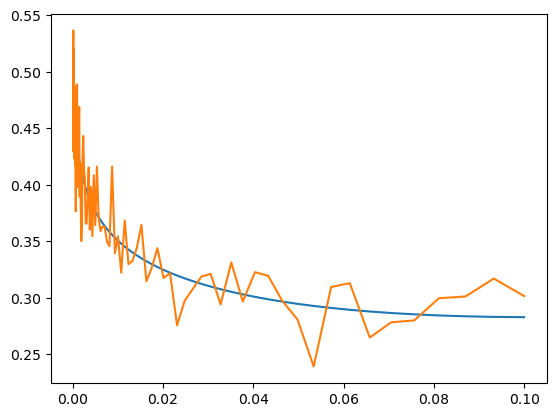

In [39]:
# svd of X
U, S, V = torch.linalg.svd(X / np.sqrt(n_train), full_matrices=False)
U.shape, S.shape, V.shape
# S, torch.linalg.eigvalsh(X.T @ X)

xi_tru = U.T @ f_tru / np.sqrt(n_train)
mu = S**2


def get_theor_mse(regparam):
    Gamma = torch.diag(mu / (mu + regparam))
    z = (torch.eye(Gamma.shape[0]) - Gamma) @ xi_tru
    bias = (z**2).sum()
    variance = (sig**2 / n_train) * torch.trace(Gamma**2)
    return bias + variance

# theor_mses = torch.zeros_like(regparams)
plt.plot(regparams, [get_theor_mse(regparam) for regparam in regparams])
plt.plot(res.regparam, res.loss)
#plt.xscale('log')
# plot S
# plt.plot(S)

In [40]:
Xn = X.numpy()
# svd of Xn
Un, Sn, Vn = np.linalg.svd(Xn, full_matrices=False)
Un.shape, Sn.shape, Vn.shape
# eigenvlues of Xn.T @ Xn
np.linalg.eigvalsh(Xn.T @ Xn), Sn**2

(array([-1.4074956e-03, -9.1314141e-04, -6.3433778e-04, -4.0083428e-04,
        -3.8209019e-04, -3.7745755e-05, -1.4239458e-05,  1.3770728e-04,
         3.5266115e-04,  4.4981274e-04,  6.9681933e-04,  1.1283584e-03,
         1.2468664e-03,  3.9831102e-03,  1.9248176e-02,  9.5632330e-02,
         4.4033986e-01,  1.8876206e+00,  7.0597854e+00,  2.9966656e+01,
         8.6593651e+01,  3.2641098e+02,  5.0000000e+02,  8.2554865e+02,
         2.5765564e+03,  8.6204180e+03], dtype=float32),
 array([8.6204180e+03, 2.5765562e+03, 8.2554865e+02, 5.0000000e+02,
        3.2641089e+02, 8.6593575e+01, 2.9966879e+01, 7.0597429e+00,
        1.8875064e+00, 4.4019723e-01, 9.5552690e-02, 1.9347882e-02,
        3.2753265e-03, 5.6299614e-04, 7.6948032e-05, 1.3488181e-05,
        1.5084953e-06, 2.2171574e-07, 1.7902281e-08, 2.6431084e-09,
        1.7710103e-10, 2.8822529e-11, 1.2867368e-12, 1.3982351e-13,
        6.0732072e-15, 1.9978405e-15], dtype=float32))

In [41]:
# covariance matrix of X
C = X.T @ X / n_train

# eigenvalues and eigenvectors of C
eigvals, eigvecs = torch.linalg.eigh(C)

eigvecs.shape

# svd of X
U, S, V = torch.linalg.svd(X / np.sqrt(n_train), full_matrices=False)
U.shape, S.shape, V.shape

# verify that V is the same as the eigenvectors of C
V.T @ torch.diag(S**2) @ V, C

# sort eigvales
idx = torch.argsort(eigvals, descending=True)
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]

S**2, eigvals

(tensor([1.7241e+01, 5.1531e+00, 1.6511e+00, 1.0000e+00, 6.5282e-01, 1.7319e-01,
         5.9934e-02, 1.4119e-02, 3.7750e-03, 8.8039e-04, 1.9111e-04, 3.8696e-05,
         6.5506e-06, 1.1260e-06, 1.5390e-07, 2.6975e-08, 3.0149e-09, 4.4328e-10,
         3.5708e-11, 5.2747e-12, 3.6827e-13, 4.7350e-14, 3.5797e-14, 3.5797e-14,
         3.5797e-14, 1.3300e-14]),
 tensor([ 1.7241e+01,  5.1531e+00,  1.6511e+00,  1.0000e+00,  6.5282e-01,
          1.7319e-01,  5.9934e-02,  1.4120e-02,  3.7751e-03,  8.8040e-04,
          1.9028e-04,  3.7374e-05,  3.3228e-06,  1.4931e-06,  8.7221e-07,
          4.8574e-07,  4.6224e-07,  4.0395e-07,  2.2911e-07,  1.2695e-07,
          1.2253e-07,  3.4381e-08, -1.3929e-07, -1.7952e-07, -2.8922e-07,
         -3.7803e-07]))